In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
!echo $CUDA_VISIBLE_DEVICES

1


In [2]:
import sys
sys.path.insert(0, "../")

import os
os.chdir("../")

In [3]:
from examples.qm9 import *
from examples.train import plot_sample_hist, eval_fn
import yaml
import matplotlib.pyplot as plt

/scratch/lim24/augmented-equivariant-flows/examples/train.py:10: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm
2023-02-06 14:59:06.260343: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-02-06 14:59:06.260494: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-02-06 14:59:06.260510: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.

In [4]:
USE_64_BIT = False
if USE_64_BIT:
    from jax.config import config
    config.update("jax_enable_x64", True)

In [5]:
cfg = DictConfig(yaml.safe_load(open("examples/config/qm9.yaml")))
cfg

{'hydra': {'job': {'chdir': False}}, 'flow': {'dim': 3, 'nodes': 29, 'n_layers': 6, 'identity_init': True, 'type': 'nice', 'fast_compile': True, 'compile_n_unroll': 1, 'egnn': {'emile_net': False, 'mlp_units': [64, 64], 'n_layers': 3, 'normalize_by_norms': True, 'variance_scaling_init': 0.001, 'tanh': False, 'agg': 'mean', 'phi_x_max': 1.0, 'normalization_constant': 1.0, 'h': {'linear_softmax': True, 'share_h': True}}, 'transformer': {'mlp_units': [64, 64], 'num_heads': 3, 'key_size': 16, 'w_init_scale': 0.1, 'n_layers': 3}}, 'training': {'lr': '6e-5', 'n_epoch': 300, 'batch_size': 32, 'plot_batch_size': 32, 'max_global_norm': None, 'seed': 0, 'reload_aug_per_epoch': True, 'train_set_size': None, 'test_set_size': None, 'n_plots': 10, 'n_checkpoints': 8, 'n_eval': 12, 'K_marginal_log_lik': 20, 'save': True, 'save_dir': 'qm9pos_results'}, 'logger': {'wandb': {'name': 'qm9pos_${flow.type}', 'project': 'fab', 'entity': 'flow-ais-bootstrap', 'tags': ['qm9pos']}}}

In [9]:
cfg.training.lr = 1e-4
cfg.flow.type = "vector_scale_shift"
cfg.flow.n_layers=3
cfg.flow.egnn.mlp_units = (16,)
cfg.flow.transformer.mlp_units = (16,)
cfg.flow.egnn.n_layers = 3
cfg.training.batch_size = 100
cfg.training.n_epoch = 10
cfg.training.save = False
cfg.training.plot_batch_size = 128
cfg.logger = DictConfig({"list_logger": None})
cfg.training.n_plots = 4
cfg.training.n_eval = 4
cfg.training.K_marginal_log_lik = 5

training data size of 13800


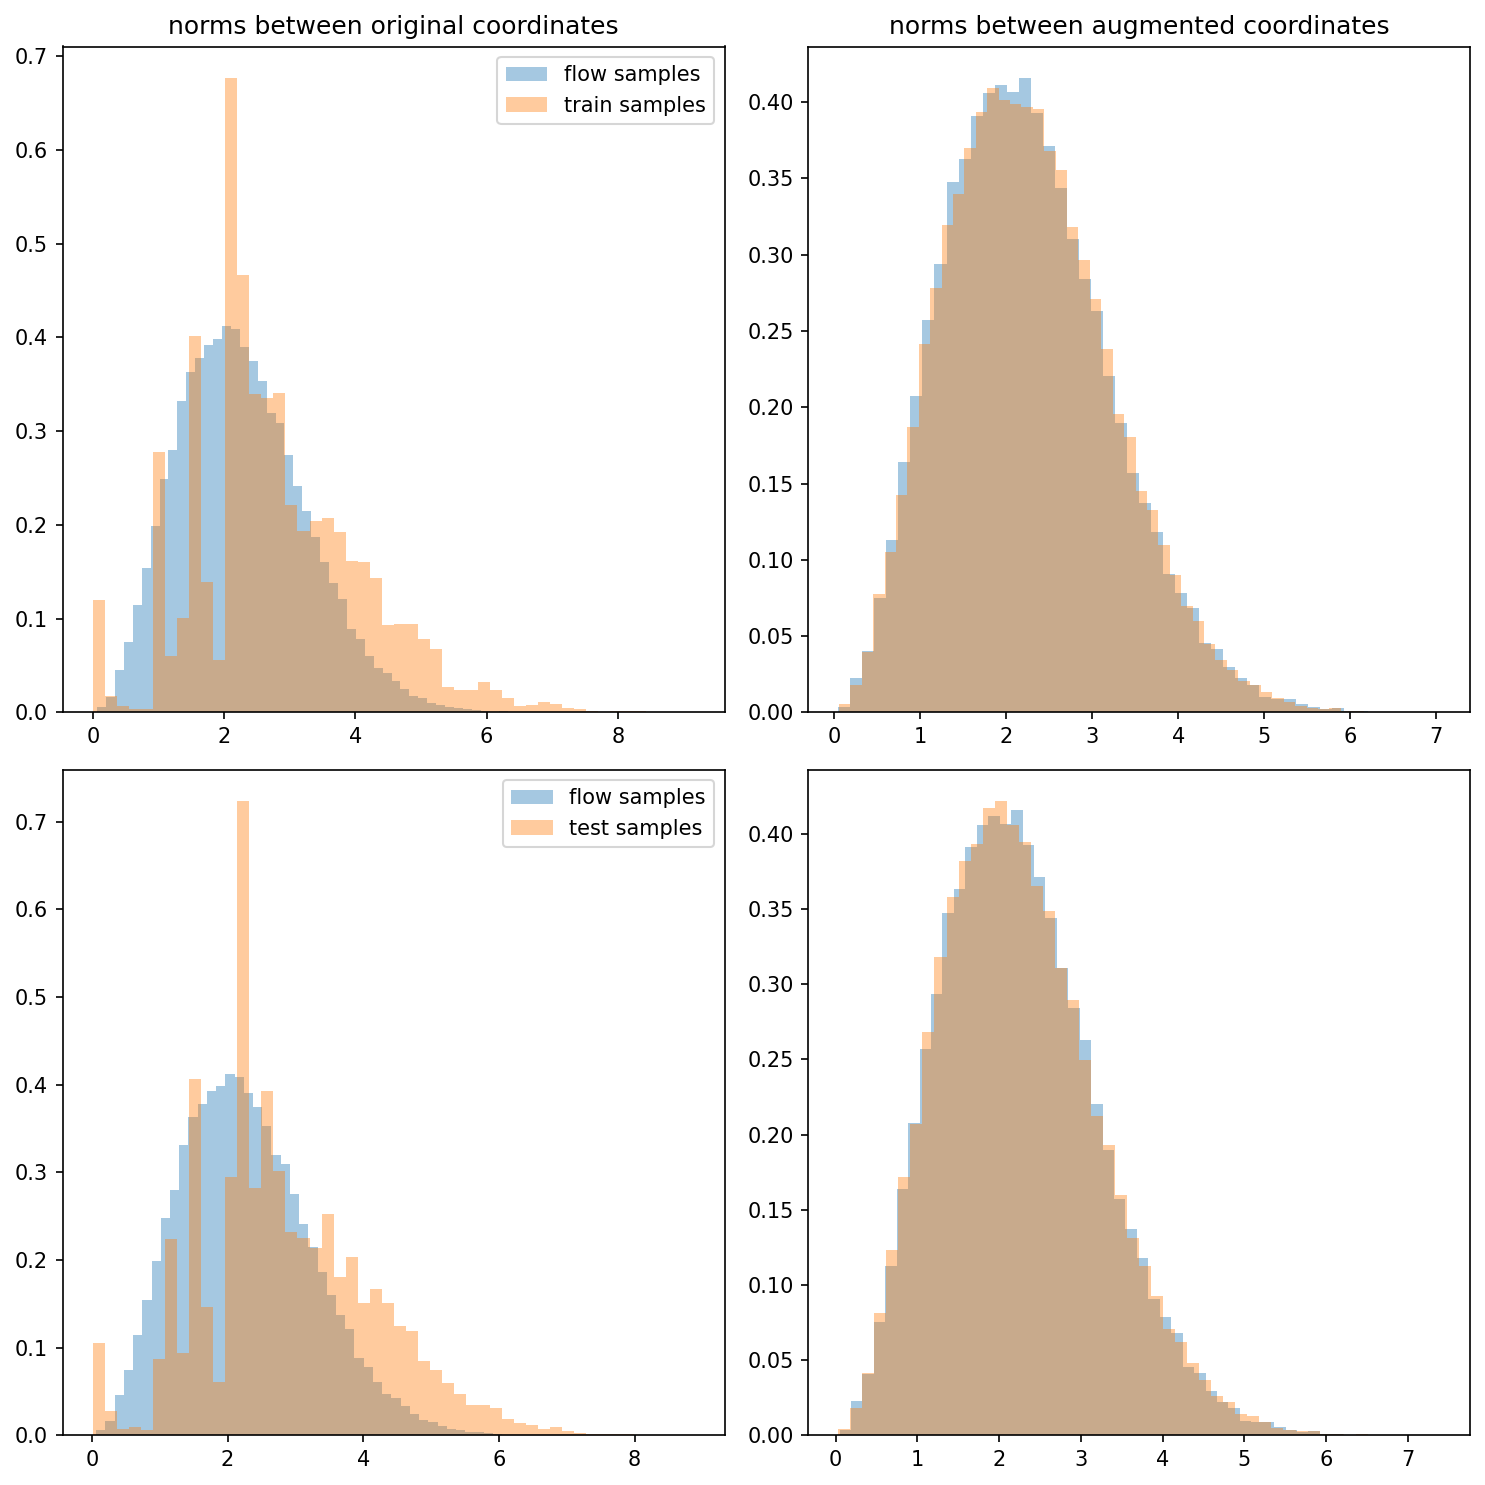

  0%|                                                                                                                                                                               | 0/10 [00:00<?, ?it/s]

non numeric history values being saved


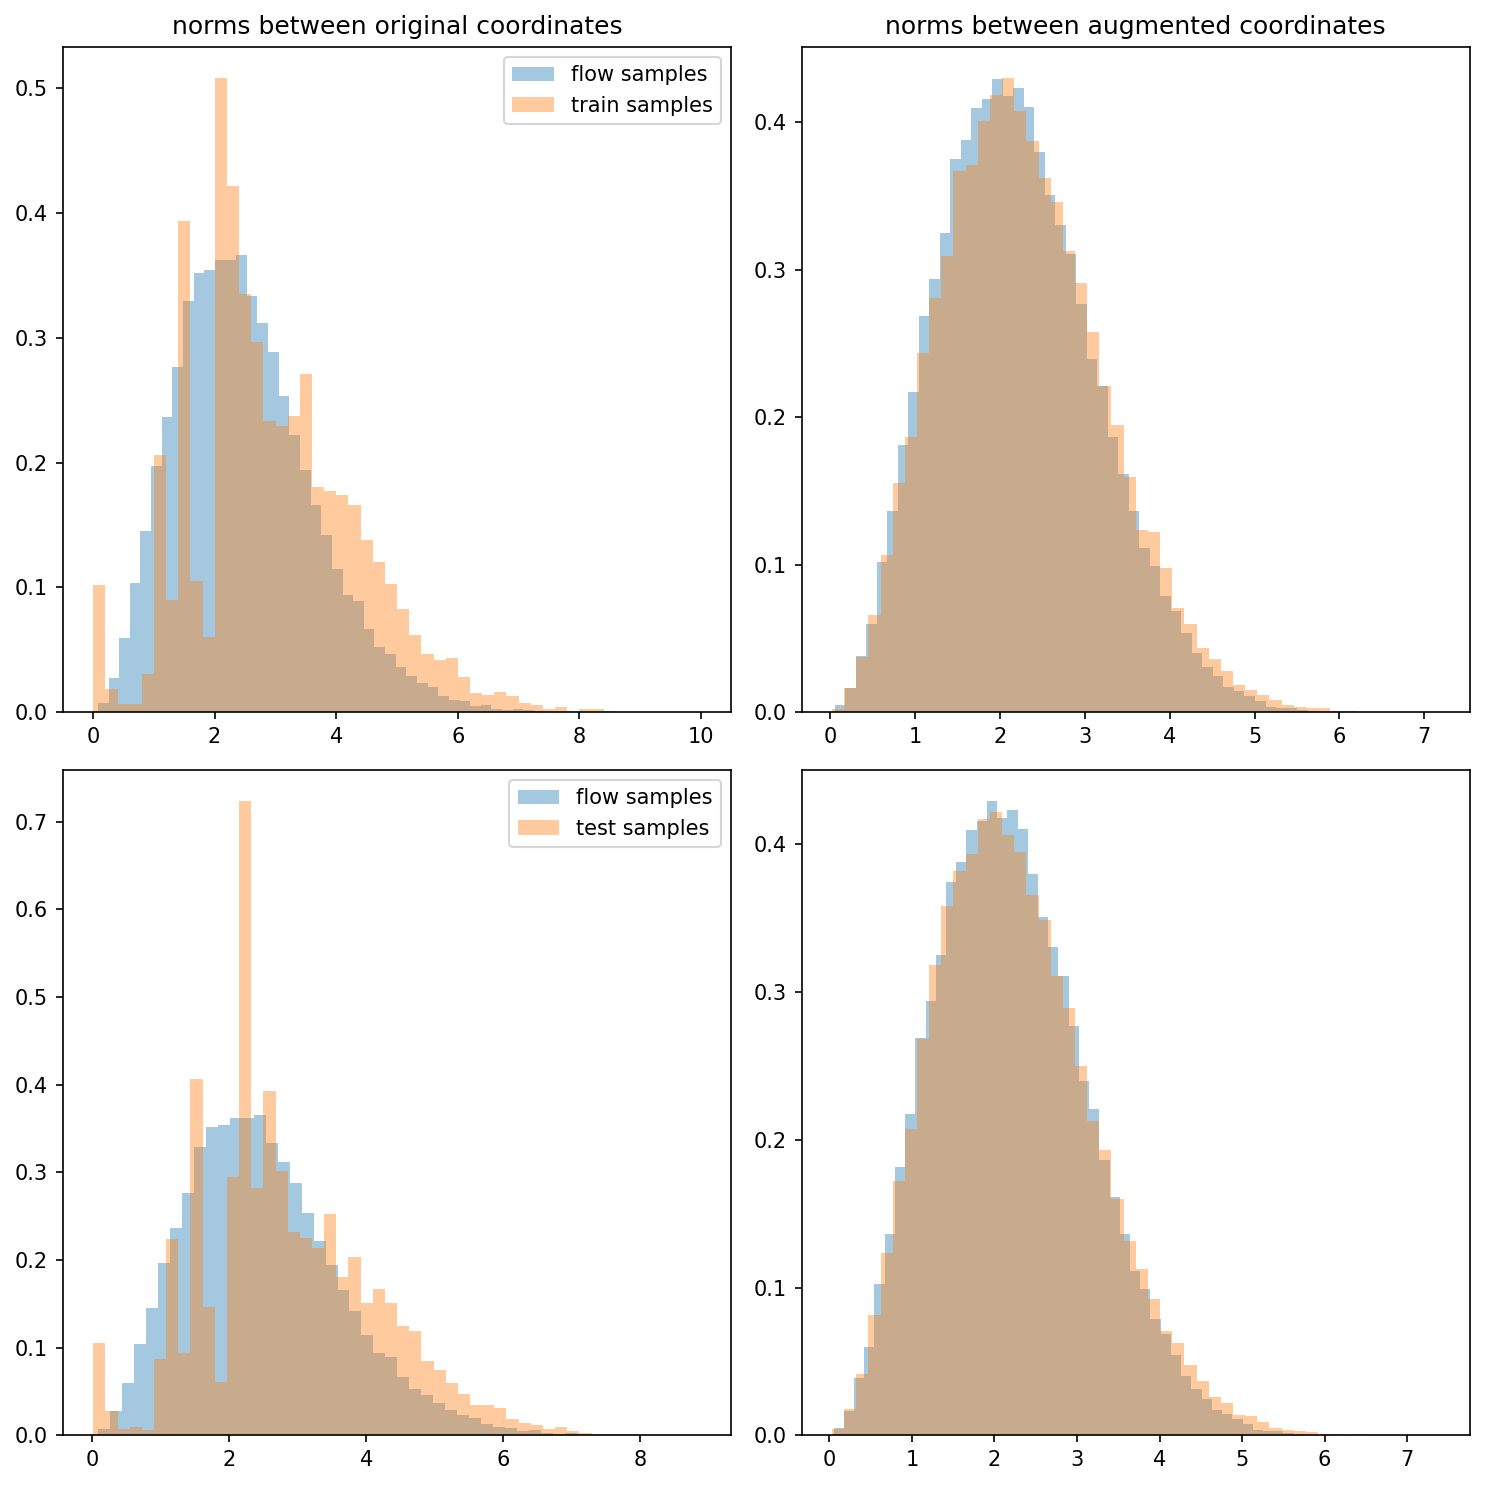

 10%|████████████████▋                                                                                                                                                      | 1/10 [01:08<10:12, 68.11s/it]

{'eval_log_lik': Array(-255.31195, dtype=float32), 'eval_marginal_log_lik': Array(-129.92549, dtype=float32)}


 30%|██████████████████████████████████████████████████                                                                                                                     | 3/10 [01:46<03:32, 30.30s/it]

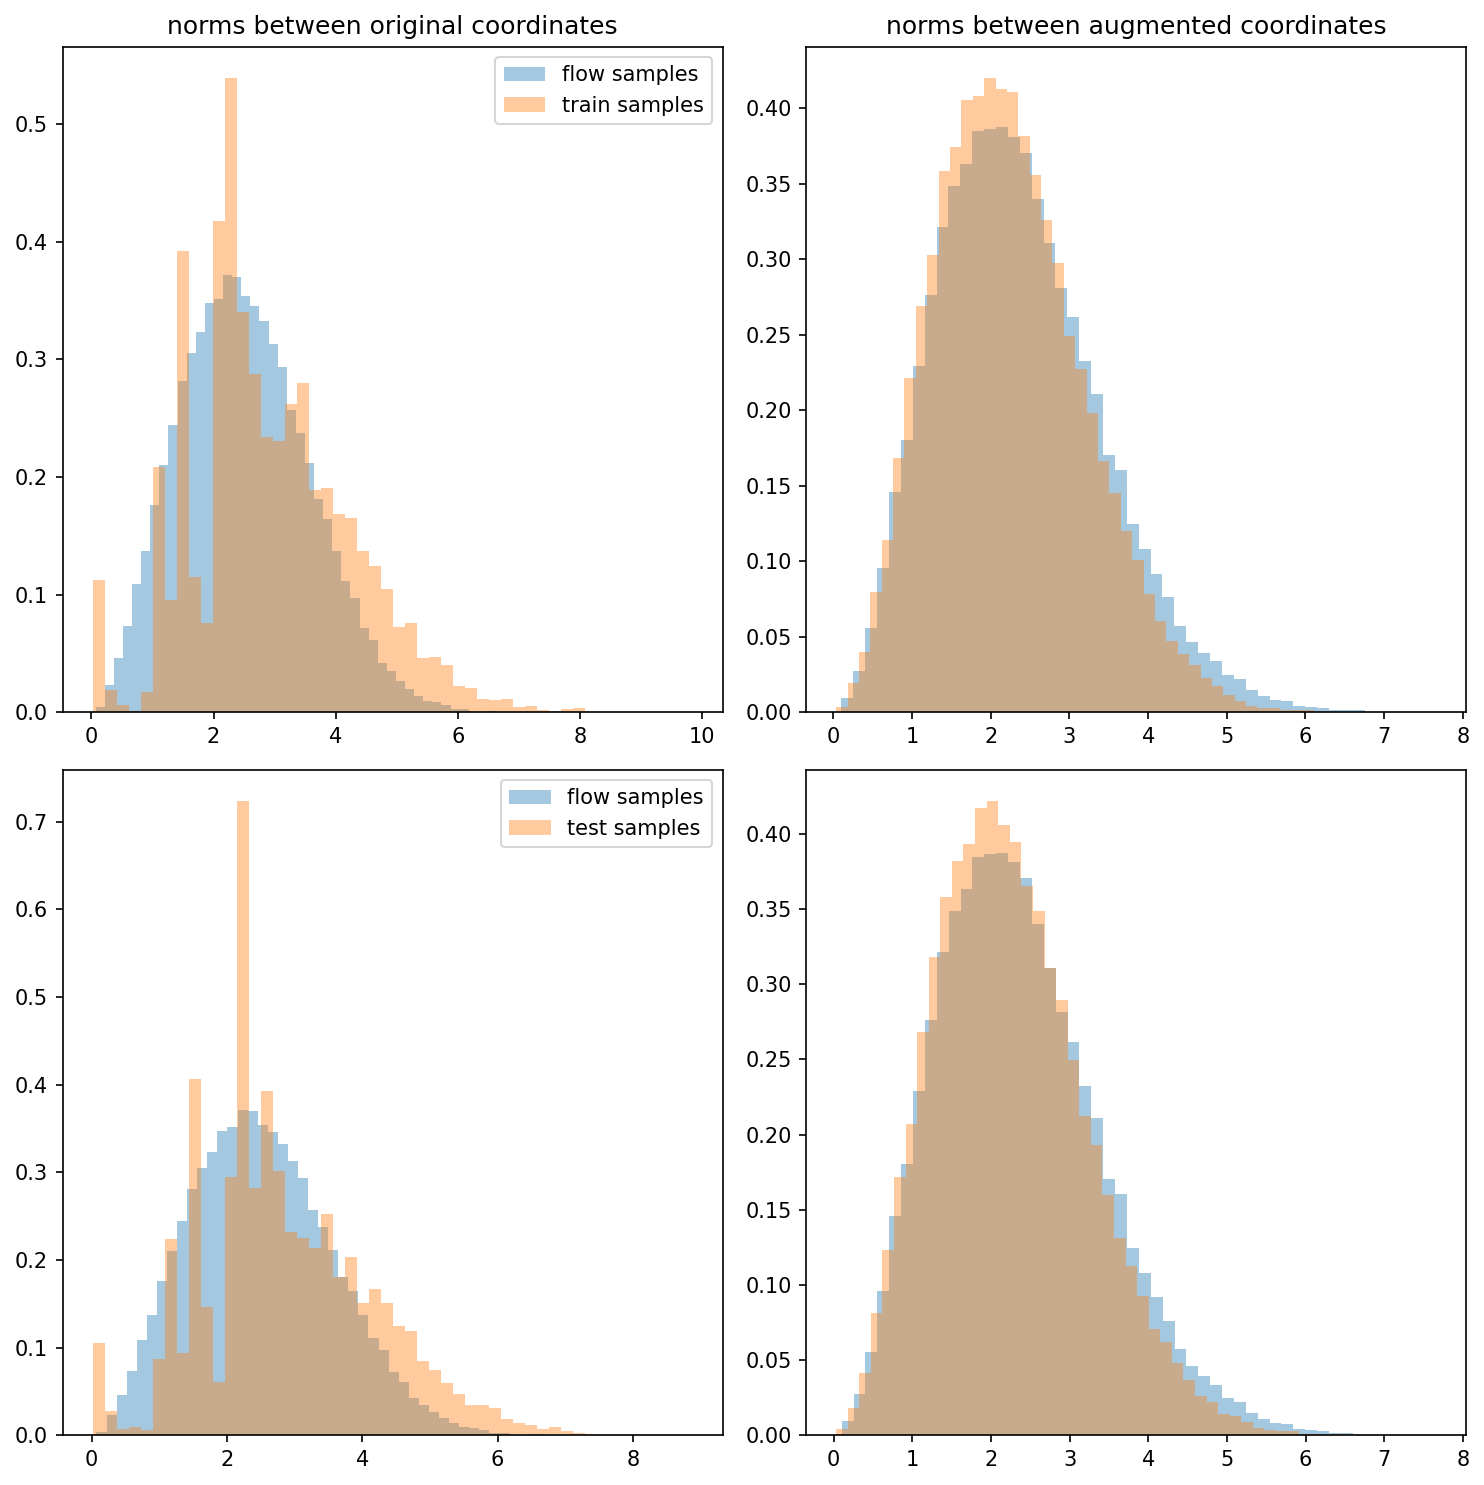

 40%|██████████████████████████████████████████████████████████████████▊                                                                                                    | 4/10 [02:33<03:40, 36.73s/it]

{'eval_log_lik': Array(-243.36765, dtype=float32), 'eval_marginal_log_lik': Array(-118.066666, dtype=float32)}


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 6/10 [03:12<01:46, 26.72s/it]

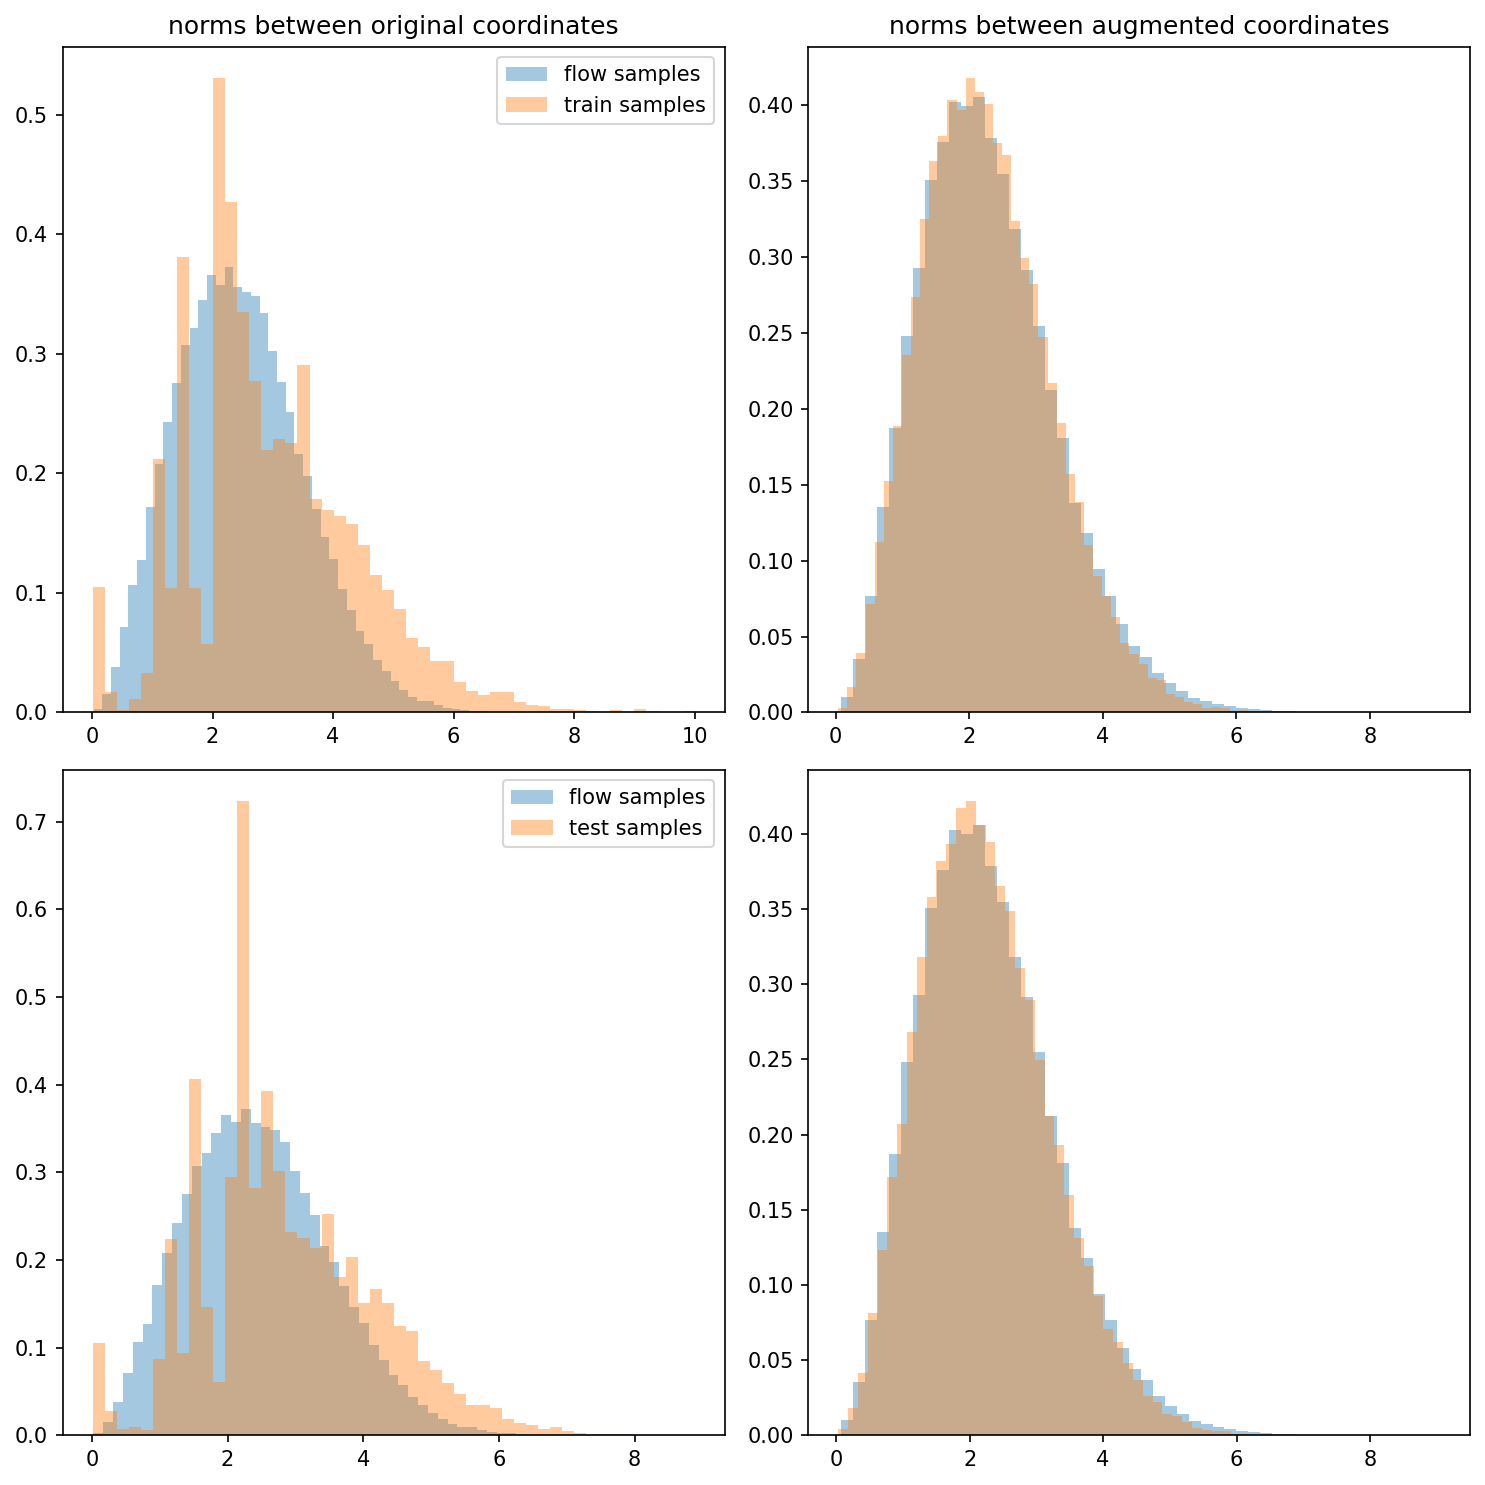

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 7/10 [03:58<01:39, 33.21s/it]

{'eval_log_lik': Array(-238.36378, dtype=float32), 'eval_marginal_log_lik': Array(-112.81801, dtype=float32)}


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 9/10 [04:37<00:25, 25.92s/it]

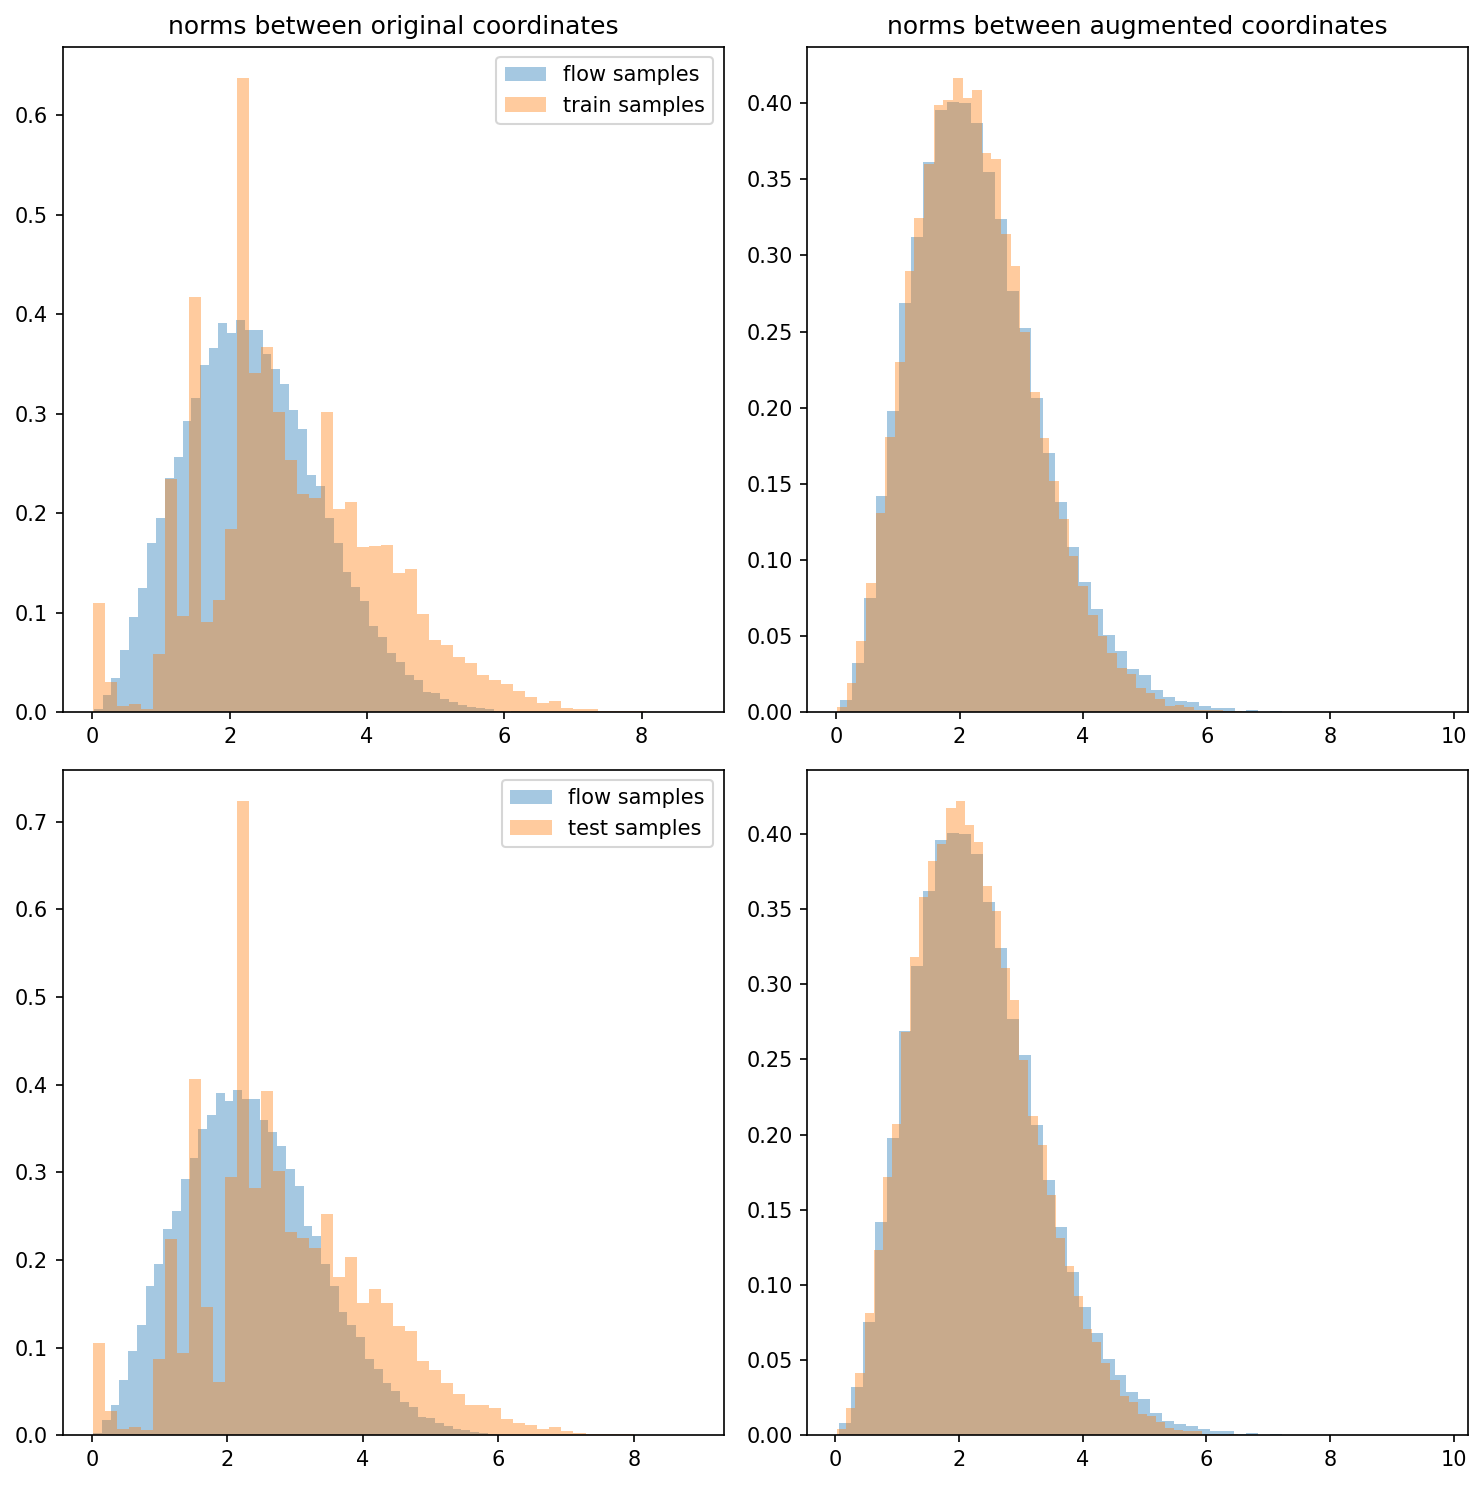

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [05:25<00:00, 32.51s/it]


{'eval_log_lik': Array(-235.21257, dtype=float32), 'eval_marginal_log_lik': Array(-109.68055, dtype=float32)}


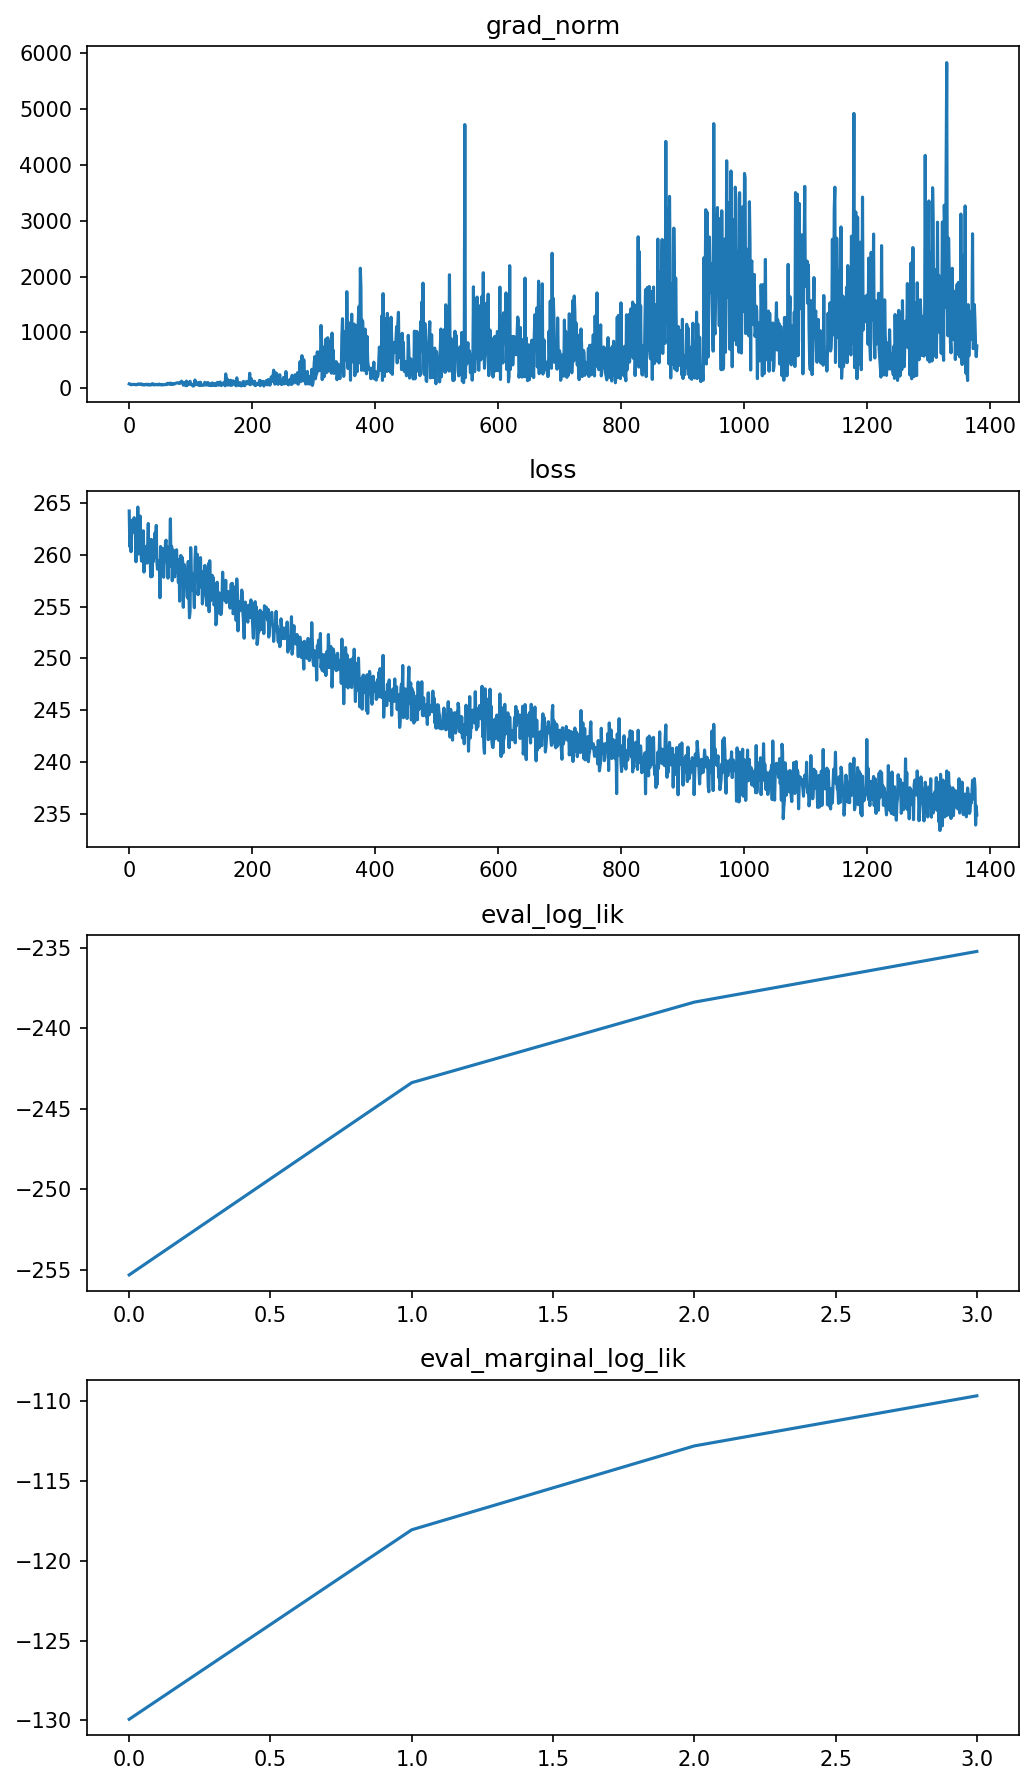

In [10]:
experiment_config = create_train_config(cfg, dim=3, n_nodes=29,
                                        load_dataset=load_dataset)

logger, params, log_prob_fn, sample_and_log_prob_fn = train(experiment_config)



In [8]:
train_data, test_data = load_dataset(batch_size=cfg.training.batch_size, train_set_size=1000, test_set_size=1000)
x = sample_and_log_prob_fn.apply(params, jax.random.PRNGKey(1), (512,))[0]

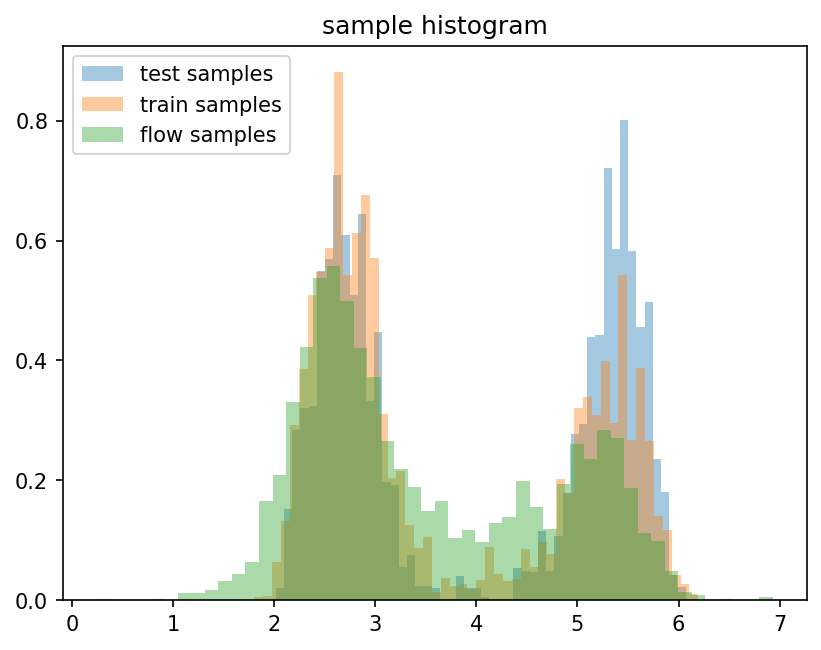

In [9]:
fig, axs = plt.subplots()
plot_sample_hist(test_data, axs, original_coords=True, label='test samples')
plot_sample_hist(train_data, axs, original_coords=True, label='train samples')
plot_sample_hist(x, axs, original_coords=True, label='flow samples')
axs.set_title("sample histogram")
axs.legend()

In [10]:
eval_fn(params=params, x=test_data, flow_log_prob_fn=log_prob_fn,
                                flow_sample_and_log_prob_fn=sample_and_log_prob_fn,
                                target_log_prob=dw4.log_prob_fn,
                                key=jax.random.PRNGKey(1), batch_size=cfg.training.batch_size,
                                K=50)

{'ess': Array(0.06202656, dtype=float32),
 'eval_kl': Array(-302.26892, dtype=float32),
 'eval_log_lik': Array(-20.014637, dtype=float32),
 'eval_marginal_log_lik': Array(-9.297838, dtype=float32)}